In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time
from statsmodels.tsa.stattools import adfuller

In [38]:
cat_df = pd.read_csv('catfish.csv', parse_dates=[0] ,index_col = [0],date_format = '%Y-%m-%d')
cat_df.head()

,Total
Date,
1986-01-01,9034
1986-02-01,9596
1986-03-01,10558
1986-04-01,9002
1986-05-01,9239


In [48]:
cat_df = cat_df.asfreq(pd.infer_freq(cat_df.index))
cat_df.head()

,Total
Date,
1986-01-01,9034
1986-02-01,9596
1986-03-01,10558
1986-04-01,9002
1986-05-01,9239


In [50]:
start_date = datetime(1996,1,1)
end_date = datetime(2000,1,1)
lim_catfish_sales = cat_df[start_date:end_date]

In [40]:
def plot_time_series(series, title='Catfish Sales', ylabel='Value', xlabel='Date', figsize=(12, 6), color='blue'):
    """
    Plots a time series with date index.

    Parameters:
        series (pd.Series): Pandas Series with datetime index.
        title (str): Title of the plot.
        ylabel (str): Y-axis label.
        xlabel (str): X-axis label.
        figsize (tuple): Size of the figure.
        color (str): Line color.
    """
    plt.figure(figsize=figsize)
    plt.plot(series, color=color, linewidth=2)
    plt.title(title, fontsize=14)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

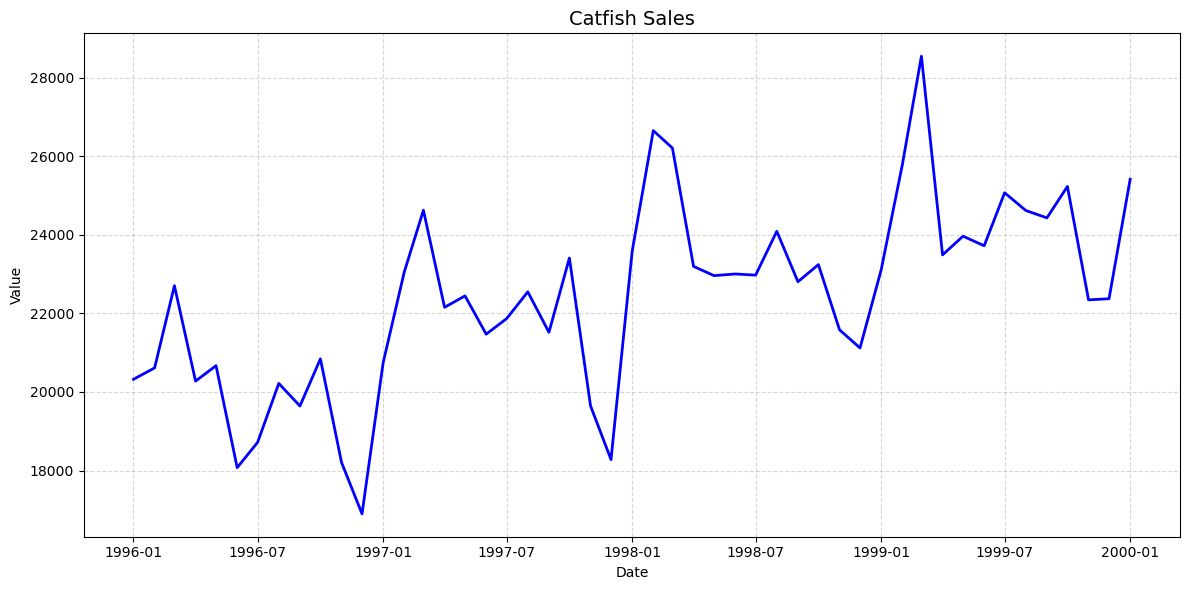

In [52]:
plot_time_series(lim_catfish_sales)

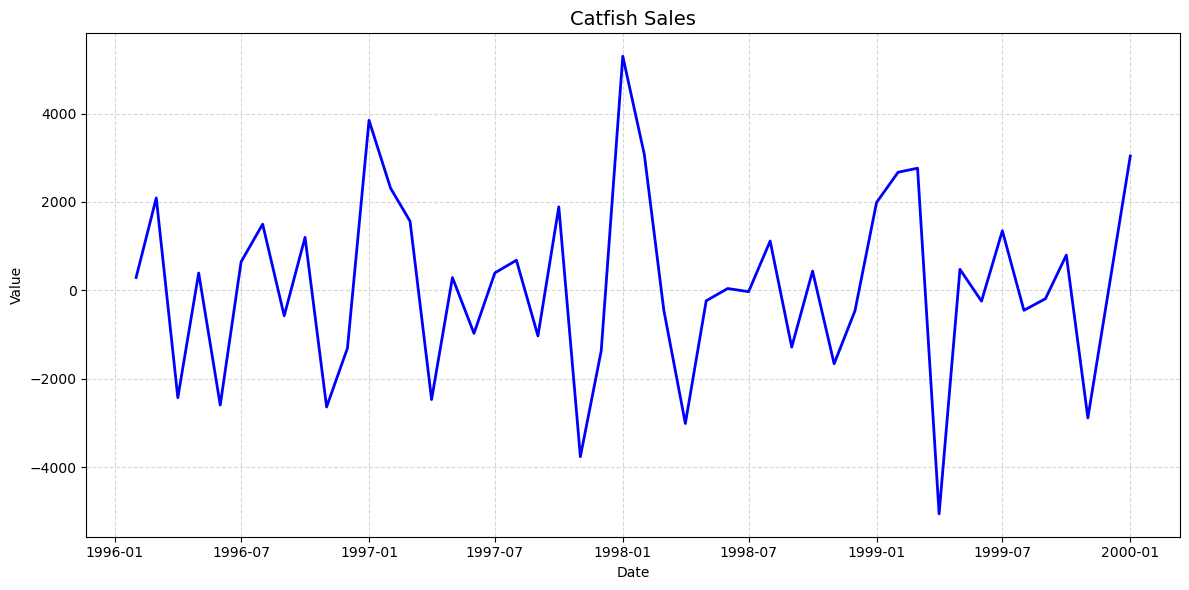

In [62]:
first_diff = lim_catfish_sales.diff()[1:]
plot_time_series(first_diff)

In [72]:
def plot_acf_pacf(series, lags=40, alpha=0.05, title_prefix=''):
    """
    Plots the ACF and PACF of a time series.

    Parameters:
        series (pd.Series): The time series data.
        lags (int): Number of lags to show.
        alpha (float): Confidence interval level.
        title_prefix (str): Prefix to add to the plot titles.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    plot_acf(series, lags=lags, ax=axes[0], alpha=alpha)
    axes[0].set_title(f'{title_prefix} ACF')

    plot_pacf(series, lags=lags, ax=axes[1], alpha=alpha, method='ywm')
    axes[1].set_title(f'{title_prefix} PACF')

    plt.tight_layout()
    plt.show()

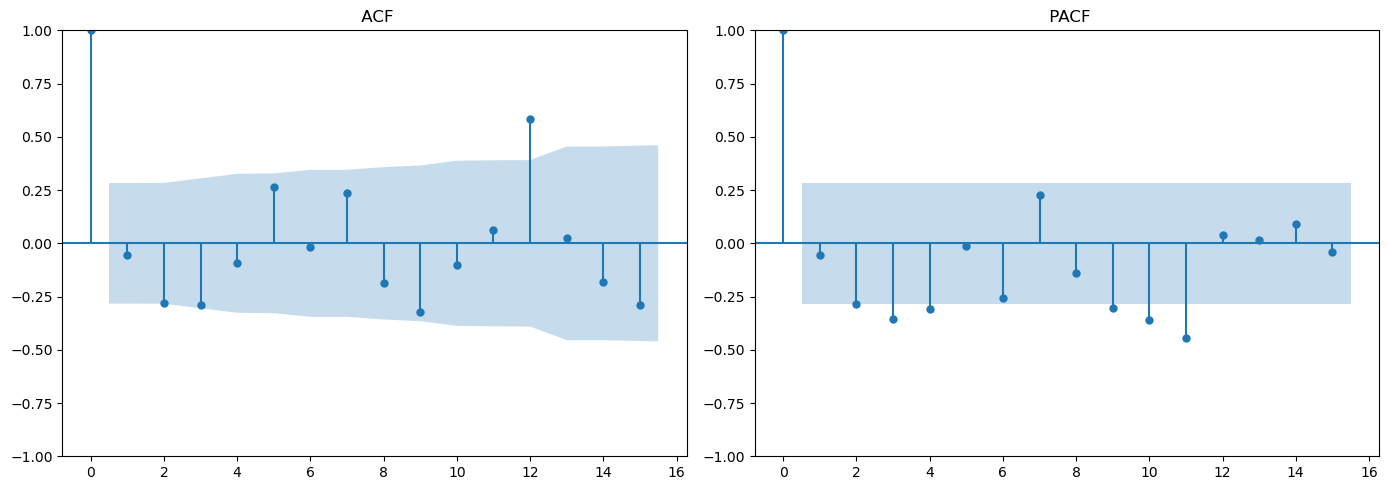

In [76]:
plot_acf_pacf(first_diff,15)

In [84]:
def check_stationarity(series, alpha=0.05, verbose=True):
    """
    Performs ADF test to check stationarity of a time series.
    
    Parameters:
        series (pd.Series): The time series data.
        alpha (float): Significance level (default 0.05).
        verbose (bool): Whether to print detailed output.
    
    Prints:
        Results of the ADF test
    """
    result = adfuller(series.dropna(), autolag='AIC')
    output = {
        'ADF Statistic': result[0],
        'p-value': result[1],
        'Used Lags': result[2],
        'Number of Observations': result[3],
        'Critical Values': result[4],
        'Stationary': result[1] < alpha
    }

    if verbose:
        print("=== ADF Test Results ===")
        print(f"ADF Statistic     : {output['ADF Statistic']:.4f}")
        print(f"p-value           : {output['p-value']:.4f}")
        print(f"Used Lags         : {output['Used Lags']}")
        print(f"Observations Used : {output['Number of Observations']}")
        print("Critical Values   :")
        for key, value in output['Critical Values'].items():
            print(f"   {key} : {value:.4f}")
        print(f"\nConclusion: The series is {'Stationary ✅' if output['Stationary'] else 'Non-Stationary ❌'} (alpha={alpha})")

In [196]:
check_stationarity(lim_catfish_sales)
check_stationarity(first_diff)

=== ADF Test Results ===
ADF Statistic     : -2.3427
p-value           : 0.1586
Used Lags         : 11
Observations Used : 37
Critical Values   :
   1% : -3.6209
   5% : -2.9435
   10% : -2.6104

Conclusion: The series is Non-Stationary ❌ (alpha=0.05)
=== ADF Test Results ===
ADF Statistic     : -9.5150
p-value           : 0.0000
Used Lags         : 10
Observations Used : 37
Critical Values   :
   1% : -3.6209
   5% : -2.9435
   10% : -2.6104

Conclusion: The series is Stationary ✅ (alpha=0.05)


In [184]:
train_data = lim_catfish_sales[:42]
test_data = lim_catfish_sales[42:]
test_data.head()

,Total
Date,
1999-07-01,25069
1999-08-01,24618
1999-09-01,24430
1999-10-01,25229
1999-11-01,22344


In [186]:
# Fit SARIMA model
order = ()
model = SARIMAX(train_data,
                order=(0, 1, 0),               # (p,d,q)
                seasonal_order=((1, 0, 1, 12)),  # (P,D,Q,s) -> Monthly seasonality
                enforce_stationarity=False,
                enforce_invertibility=False)

model_fit = model.fit(disp=False)

# Print model summary
print(results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                Total   No. Observations:                   40
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -231.319
Date:                              Thu, 24 Apr 2025   AIC                            468.637
Time:                                      02:15:26   BIC                            472.412
Sample:                                  02-01-1996   HQIC                           469.724
                                       - 05-01-1999                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.3101      0.274      1.133      0.257      -0.226       0.847
ma.S.L12       1.21

In [188]:
#get the predictions and residuals
predictions = model_fit.forecast(len(test_data))
predictions = pd.DataFrame(predictions, index=test_data.index)
predictions.rename(columns={'predicted_mean': 'Total'}, inplace=True)
residuals = test_data - predictions
print(residuals)

                  Total
Date                   
1999-07-01  1264.262932
1999-08-01   -71.421047
1999-09-01   738.762274
1999-10-01   880.102997
1999-11-01  -194.692581
1999-12-01   422.821335
2000-01-01  1022.254312


Text(0, 0.5, 'Error')

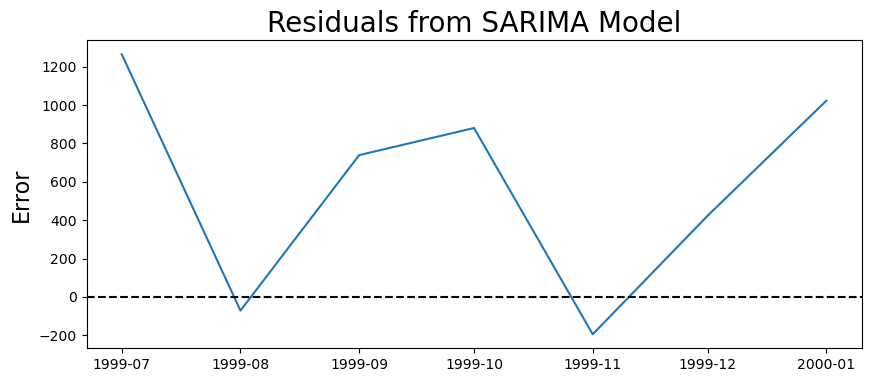

In [190]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

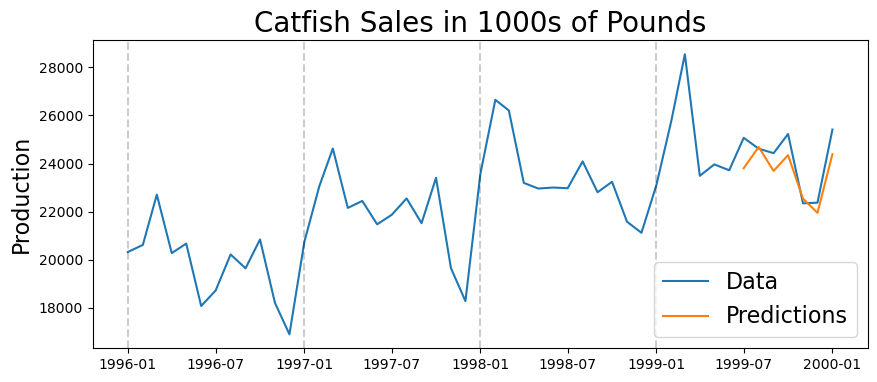

In [192]:
plt.figure(figsize=(10,4))

plt.plot(lim_catfish_sales)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [194]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data)),4))
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Mean Absolute Percent Error: 0.0266
Root Mean Squared Error: 773.2583812981317
